**CS6140 Final project: DCGAN with WGAN-GP trainer**

# Import and defining classes

In [ ]:
    # === Uncomment to clone and access repo 
!git clone https://github.com/timmytonga/gans-vi 
%cd gans-vi
# !git pull
!ls

Cloning into 'gans-vi'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 126 (delta 77), reused 60 (delta 26), pack-reused 0
Receiving objects: 100% (126/126), 38.92 KiB | 12.97 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/gans-vi/gans-vi
dcgan_models.py      inception_score.py		 train_wgan_gp_extra.py
extraSGD.py	     README.md			 train_wgan_gp.py
fit_extrapastsgd.py  resnet_models.py		 utils.py
fit_extrasgd.py      train_wgan_gp_extrapast.py  wgan_gp_loss.py


In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
# torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

from dcgan_models import Generator, Discriminator
from wgan_gp_loss import disc_loss_wgan_gp, gen_loss_wgan_gp
from utils import make_noise, show_tensor_images, get_cur_timestamp


from tqdm.auto import tqdm  # for visualizing progress per epoch
import time
import copy


### [Optional] Setting up Google Drive for Loading and Saving checkpoints

In [ ]:
# first, setting up check-point directory (we want this to be on a permanent storage like google drive or local)
# first mount the google drive here, hello
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls ../drive/My\ Drive/datafor6140

ls: cannot access '../drive/My Drive/cs6140/extraSGDNorm2': No such file or directory


# TRAINING

In [ ]:
# =========================================================================== #
#                  FIRST, MUST MAKE SURE PATHS ARE CORRECT                    #
# =========================================================================== #
CHECKPOINT_PATH="/content/drive/My Drive/cs6140/extraSGDNorm2/"
SAVE_MODEL_PATH="/content/drive/My Drive/cs6140/extraSGDNorm2/"
DISC_PATH = SAVE_MODEL_PATH + 'disc_weight.pth'
GEN_PATH = SAVE_MODEL_PATH + 'gen_weight.pth'


# =========================================================================== #
#                  SET ANY CHECKPOINT FILE HERE (ignore if no checkpoint)     #
# =========================================================================== #
CHECKPOINTFILENAME = "[25-Nov-2020(07:07)]checkpoint.pt"
CHECKPOINTFILEPATH = CHECKPOINT_PATH + CHECKPOINTFILENAME  # change the last part
ENABLE_CHECKPOINT = True

In [ ]:
# =========================================================================== #
#                  GET MODELS                                                 #
# =========================================================================== #
from dcgan_models import Discriminator, Generator

wgan_gp = True    # do we want to do WGAN or WGAN-GP?

device = 'cpu'
if torch.cuda.is_available():  # use gpu if available
	device = 'cuda'


gen = Generator().to(device)
disc = Discriminator().to(device)
gen2 = Generator().to(device)
disc2 = Discriminator().to(device) 

### Setting up hyperparameters and environment variables

Files already downloaded and verified


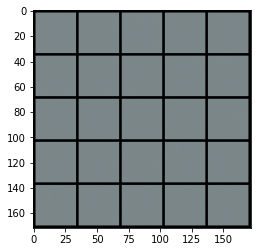

In [ ]:
# =========================================================================== #
#                   HYPERPARAMETERS AND TRAINING DATA                         #
# =========================================================================== #
z_dim = 128
lr = 0.00002      # learning rate
if wgan_gp:       # according to varineq paper
	lr_d = 0.0001
	lr_g = 0.00001
beta_1 = 0.5      # first moment's momentum (ADAM hyperparam)
beta_2 = 0.9      # second moment's momentum
weight_clipping = 0.01
c_lambda = 10     # for gradient penalty
batch_size = 64

# get data and loader
transform_train = transforms.Compose([
	# transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


trainset = DataLoader(CIFAR10(root='.', download=True, transform=transform_train), batch_size=batch_size, shuffle=True)
#trainset2 = DataLoader(CIFAR10(root='.', download=True, transform=transform_train), batch_size=batch_size, shuffle=True)


# before training initialize weight
def weights_init(m):
	if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
		torch.nn.init.normal_(m.weight, 0.0, 0.02)
	if isinstance(m, nn.BatchNorm2d):
		torch.nn.init.normal_(m.weight, 0.0, 0.02)
		torch.nn.init.constant_(m.bias, 0)
	
def weights_init_zero(m):
	if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
			torch.nn.init.constant_(m.weight, 0.0)
	if isinstance(m, nn.BatchNorm2d):
			torch.nn.init.constant_(m.weight, 0.0)
			torch.nn.init.constant_(m.bias, 0.0)


gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
gen2 = gen2.apply(weights_init_zero)
disc2 = disc2.apply(weights_init_zero)

show_tensor_images(gen(make_noise(25, z_dim, device=device)),unnorm_mean = (0.5, 0.5, 0.5), unnorm_var=(0.5, 0.5, 0.5))

In [ ]:
# =========================================================================== #
#                  SET OPTIMIZERS HERE                                        #
# =========================================================================== #
import pytz
from datetime import datetime
from extraSGD import extraSGD

# define the Adam optimizers
# gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
# disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# define SGD 
gen_opt = extraSGD(gen.parameters(), lr=lr_g)
disc_opt = extraSGD(disc.parameters(), lr=lr_d)

# =========================================================================== #
#                  SET LOSS FUNCTIONS FOR FITTING                             #
# =========================================================================== #
disc_loss_fn = disc_loss_wgan_gp
gen_loss_fn = gen_loss_wgan_gp

def get_cur_timestamp():
	tz_NY = pytz.timezone('America/New_York')
	dateTimeObj = datetime.now(tz_NY)
	return dateTimeObj.strftime("[%d-%b-%Y(%H:%M)]")

get_cur_timestamp()

'[27-Nov-2020(16:33)]'

In [ ]:
# =========================================================================== #
#                  SET VALIDATION STUFF                                       #
# =========================================================================== #
from inception_score import inception_score
torch.manual_seed(0)
validation_noise = make_noise(25, z_dim, device=device)  # so we have a fixed validation noise
torch.manual_seed(int(time.time()))  # this should be random enough for fitting


valimg = gen(validation_noise)
test_score = inception_score(valimg, cuda=True, batch_size=batch_size, resize=True, n_sec=1)
# inception_score(IS_fake, cuda=True, batch_size=32, resize=True, n_sec=8)
print(test_score)

(1.0087890271093418, 0.0)


In [ ]:
print(torch.cuda.get_device_name(), torch.cuda.get_device_capability())

Tesla T4 (7, 5)


### FITTING

In [ ]:
# =========================================================================== #
#                  FITTING                                                    #
# =========================================================================== #
display_step = 500  # for displaying info after this many step (i.e. batch)
disc_repeats = 1  # how many times to train the discriminator per one generator
check_point_after_epochs = 10  # checkpointing every these epochs
n_epochs = 501
save_dict = None  # backup checkpoint for manual saving


def fit(checkpt=True, loadcheckptpath=None, CHECKPOINT_NAME_TAG="checkpoint.pt"):
	""" fit the models gen, disc in global var
	CHECKPOINT_NAME_TAG specifies the naming for the checkpoint file
	"""
	# ================================================================== #
	#       Initialize training vars and load checkpt if any             #
	# ================================================================== #
	step = 0
	generator_losses = []
	disc_losses = []
	inception_scores = []
	avgmodel_inception_scores = []
	img_history = []
	avgmodel_image_history = []
	last_epoch = 0
	gen2_losses = []
	disc2_losses = []

	if loadcheckptpath is not None:  # we were provided with checkpt. Load and resume
		print(f"========= Checkpoint found! Resuming training from last checkpoint at ======== \n{loadcheckptpath}")
		print("Loading checkpoint...")
		checkpoint = torch.load(loadcheckptpath)
		print("Checkpoint loaded successfully! Info:")
		last_epoch = checkpoint['epoch'] + 1
		print(f"\tLast epoch: {last_epoch - 1}")
		disc.load_state_dict(checkpoint['disc_state_dict'])
		gen.load_state_dict(checkpoint['gen_state_dict'])
		disc2.load_state_dict(checkpoint['disc2_state_dict'])
		gen2.load_state_dict(checkpoint['gen2_state_dict'])
		disc_opt.load_state_dict(checkpoint['disc_opt_state_dict'])
		gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
		print(f"\tLoaded discriminator and generator's old weight and state_dict")
		generator_losses = checkpoint['generator_losses']
		disc_losses = checkpoint['disc_losses']
		gen2_losses = checkpoint['gen2_losses']
		disc2_losses = checkpoint['disc2_losses']
		print(f"\tLoaded losses history.")
		step = checkpoint['step']
		print(f"\tLast step: {step}")
		img_history = checkpoint['img_history']
		inception_scores = checkpoint['inception_scores']
		avgmodel_image_history = checkpoint['avgmodel_image_history'] 
		avgmodel_inception_scores = checkpoint['avgmodel_inception_scores'] 
		print("Loaded img_history and inception_scores")
		print("===================== FINISHED LOADING LAST CHECKPOINT. TRAINING ===========")
	else:
		print("Checkpoint not found. Below is the first image with the validation noise.")
		firstimg = gen(validation_noise)
		show_tensor_images(firstimg,unnorm_mean = (0.5, 0.5, 0.5), unnorm_var=(0.5, 0.5, 0.5))
		img_history += [firstimg]

	# ==================== BEGIN TRAINING ==================== #
	print("Training with", device)
	for epoch in range(last_epoch, n_epochs):
		# make sure the models are set to training
		gen.train()
		disc.train()
		print(f"EPOCH: {epoch}")
		# Dataloader returns the batches
		for real, label in tqdm(trainset):  # tqdm is just a progress bar
			cur_batch_size = len(real)
			real = real.to(device)  # load to GPU if enabled
			#real2 = real2.to(device)
	 
			noise = make_noise(cur_batch_size, z_dim, device=device)
			fake = gen(noise)
			disc_t = copy.deepcopy(disc)
			fake_score = disc_t(fake)
			gen_loss = gen_loss_fn(fake_score)
			disc_loss = disc_loss_fn(disc, real, fake, device, c_lambda)
		
			if step%2==0:

				# ================================================================== #
				#                      Extra the discriminator                       #
				# ================================================================== #
				
				# compute the loss (loss fn set above)
				for p in gen.parameters():
					p.requires_grad = False
				disc_opt.zero_grad()  # first zero out the grad	
				#disc_loss = disc_loss_fn(disc, real, fake, device, c_lambda)
				# Update gradients
				disc_loss.backward(retain_graph=True)
				# Update optimizer
				disc_opt.extra()
				for p in gen.parameters():
					p.requires_grad = True
				# ================================================================== #
				#                      Extra the generator                           #
				# ================================================================== #
				disc_losses += [disc_loss.item()]  # add the loss for visualization
				for p in disc.parameters():
						p.requires_grad = False
				# first zero out the gradients
				gen_opt.zero_grad()
				
				# compute the scores and losses
				#gen_loss = gen_loss_fn(fake_score)
				# backprop i.e. compute the gradient
				gen_loss.backward(retain_graph= True)
				# Update the weights
				gen_opt.extra()
				for p in disc.parameters():
					p.requires_grad = True

				# Keep track of the generator loss
				generator_losses += [gen_loss.item()]
			else:
				


				# ================================================================== #
				#                      Train the discriminator                       #
				#																																		 #
				# ================================================================== #
				# compute the loss (loss fn set above)
				for p in gen.parameters():
					p.requires_grad = False
				disc_opt.zero_grad()  # first zero out the grad
				#disc_loss = disc_loss_fn(disc, real, fake, device, c_lambda)
				# Update gradients
				disc_loss.backward(retain_graph=True)
				# Update optimizer
				disc_opt.step()
				for p in gen.parameters():
					p.requires_grad = True

				# ================================================================== #
				#                      Train the generator                           #
				# ================================================================== #
				for p in disc.parameters():
						p.requires_grad = False
				# first zero out the gradients
				gen_opt.zero_grad()
				# compute the scores and losses
				#gen_loss = gen_loss_fn(fake_score)
				# backprop i.e. compute the gradient
				gen_loss.backward(retain_graph = True)
				# Update the weights
				gen_opt.step()
				for p in disc.parameters():
					p.requires_grad = True

			step+=1
			# ================================================================== #
			#                               Average                              #
			# ================================================================== #
			if step%2==1:
					# compute the loss for the averaged disc
				noise = make_noise(cur_batch_size, z_dim, device=device)
				fake = gen2(noise) 
				disc2_loss = disc_loss_fn(disc2, real, fake, device, c_lambda)
				disc2_losses += [disc2_loss.item()]
				fake_score = disc2(fake)
				gen2_loss = gen_loss_fn(fake_score)
				gen2_losses += [gen2_loss.item()]
							
						# update the avg weights
				with torch.no_grad():
						for name, p in disc.named_parameters():
								q = disc2.state_dict()[name]
								q = ((step-1)*q +p)/step 
								new_state_dict = {name: q}
								disc2.load_state_dict(new_state_dict, strict=False)

				with torch.no_grad():
						for name, p in gen.named_parameters():
								q = gen2.state_dict()[name]
								q = ((step-1)*q +p)/step 
								new_state_dict = {name: q}
								gen2.load_state_dict(new_state_dict, strict=False)

			

		# ================================================================== #
		#                       Validation                                   #
		# ================================================================== #
		gen.eval()
		disc.eval()
		print(f"================= VALIDATION for EPOCH {epoch}==================")
		print("-Overall losses:")
		## plot total losses after each epoch
		plt.plot(
			# range(num_examples // step_bins),
			# torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
			range(len(generator_losses)),
			generator_losses,
			label="Generator Loss"
		)
		plt.plot(
			# range(num_examples // step_bins),
			# torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
			range(len(disc_losses)),
			disc_losses,
			label="Discriminator Loss"
		)		
  		# plot the avg weight models' losses
		plt.plot(
			# range(num_examples // step_bins),
			# torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
			range(len(gen2_losses)),
			gen2_losses,
			label="Avg Weight Generator Loss"
		)
		plt.plot(
			# range(num_examples // step_bins),
			# torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
			range(len(disc2_losses)),
			disc2_losses,
			label="Avg Weight Discriminator Loss"
		)
		plt.ylabel('loss')
		plt.xlabel('number of batches processed')
		plt.title('Loss over numbatches for discriminator and generator')
		plt.legend()
		plt.show()
		

		print("Showing Validation Images")
		valimg = gen(validation_noise)
		avgmodel_valimg = gen2(validation_noise)
  
		show_tensor_images(valimg, unnorm_mean = (0.5, 0.5, 0.5), unnorm_var=(0.5, 0.5, 0.5))
  
		img_history += [valimg]
		avgmodel_image_history += [avgmodel_valimg]
		print("Showing Avg Validation Images")
		show_tensor_images(gen(make_noise(25, z_dim, device=device)), unnorm_mean = (0.5, 0.5, 0.5), unnorm_var=(0.5, 0.5, 0.5))

		# === We validate our progress by measuring inception score on "validation noise" that we fixed in the beginning =====
		incept_score = inception_score(valimg, cuda=True, batch_size=batch_size, resize=True, n_sec=1)[0]
		avgmodel_incept_score = inception_score(avgmodel_valimg, cuda=True, batch_size=batch_size, resize=True, n_sec=1)[0]
		inception_scores.append(incept_score)
		avgmodel_inception_scores.append(avgmodel_incept_score)
		plt.plot(
			range(len(inception_scores)),
			inception_scores,
			label="No Averaging"
		)
		plt.plot(
			range(len(avgmodel_inception_scores)),
			avgmodel_inception_scores,
			label="With Averaging"
		)
		plt.xlabel("Epoch")
		plt.ylabel("Inception Score")
		plt.title("Inception Scores over Epochs")
		plt.legend()
		plt.show()

		# ================================================================== #
		#                      Check-pointing                                #
		# ================================================================== #

		if checkpt and epoch % check_point_after_epochs == 0 and epoch > 0:
			timestamp = get_cur_timestamp()
			checkpt_file_path = CHECKPOINT_PATH + timestamp+"extraSGD"+ str(epoch) + CHECKPOINT_NAME_TAG
			print(f"*** EPOCH {epoch} SAVING CHECKPOINTS AT {checkpt_file_path} ***")
			save_dict = {
				'epoch': epoch,
				'disc_state_dict': disc.state_dict(),
				'gen_state_dict': gen.state_dict(),
				'disc2_state_dict': disc2.state_dict(),
				'gen2_state_dict': gen2.state_dict(),
				'disc_opt_state_dict': disc_opt.state_dict(),
				'gen_opt_state_dict': gen_opt.state_dict(),
				'generator_losses': generator_losses,
				'disc_losses': disc_losses,
				'gen2_losses': gen2_losses,
				'disc2_losses': disc2_losses,
				'step': step,
				'img_history': img_history,
				'inception_scores': inception_scores,
				'avgmodel_image_history': avgmodel_image_history,
				'avgmodel_inception_scores': avgmodel_inception_scores
			}
			torch.save(save_dict, checkpt_file_path)


# FIT WITHOUT CHECKPOINTS ####
fit()

# USE THIS FIT VERSION FOR FITTING WITH CHECKPOINTS ###
fit(checkpt=ENABLE_CHECKPOINT, loadcheckptpath=CHECKPOINTFILEPATH)

In [ ]:
print(save_dict)

# Evaluation

## Inception Score

### Define Inception Score

In [ ]:
# get inception score for p(y|x)
# p_yx => p(y|x), where p_yx[y][x] = p(y|x)
# eps is  arbitrarily small non-zero value
import torchvision 
import numpy as np

def getIS(p_yx, eps=(1E-16)):
    # p(y) by averaging over x
    p_y = p_yx.mean(axis=0)
    p_y = np.expand_dims(p_y,0)                           # make dimensions of p_yx and p_y compatible
    # KL-divergence for each x
    KL = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))  # use eps to deal with possible zeros
    # sum KL divergences over classes, and average over images
    KLsum = KL.sum(axis=1)
    KLavg = np.mean(KLsum)
    is_score = np.exp(KLavg)                              # undo the logs
    return is_score

# data is the set of images
def inception_score(data, cuda=False, batch_size=32, resize=False, n_sec=1, eps=1E-16, print_tag=False):
    N = len(data)
    # Set up CUDA option
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("You should use cuda=True, you can do it!")
        dtype = torch.FloatTensor
    # set up data loader
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # set up Inception V3 model
    model = torchvision.models.inception_v3(pretrained=True, transform_input=False).type(dtype)
    model.eval()
    up = torch.nn.Upsample(size=(299,299), mode='bilinear', align_corners=False).type(dtype)

    # helpful prediction function
    def predict(x):
        if resize:
            x = up(x)
        x = model(x)
        return torch.nn.functional.softmax(x, dim=1).data.cpu().numpy()

    # Do predictions
    all_pyx = np.zeros((N,1000))
    for i, batch in enumerate(loader, 0):
        if print_tag:
            print("Batch " + str(i))
        batch = batch.type(dtype)
        batchv = torch.autograd.Variable(batch)
        batch_size_i = batch.size()[0]
        if print_tag:
            print("Built batch")
        # actual prediction:                  Use batch_size_i to handle uneven batch
        all_pyx[i*batch_size:i * batch_size + batch_size_i] = predict(batchv)
        if print_tag:
            print("Predicted batch")

    # Split and compute scores
    sec_scores = []

    for i in range(n_sec):
        if print_tag:
            print("Section " + str(i))
        sec = all_pyx[i * (N // n_sec):(i+1) * (N // n_sec), :]
        sec_scores.append(getIS(sec, eps))

    return np.mean(sec_scores), np.std(sec_scores)

### Get inception score from generator

In [ ]:
IS_SAMPLE_SIZE = 1024

# First, generator random sample
IS_noise = make_noise(IS_SAMPLE_SIZE, z_dim, device=device)
IS_fake = gen(IS_noise)

# Then, evaluate
if torch.cuda.is_available():
  IS = inception_score(IS_fake, cuda=True, batch_size=32, resize=True, n_sec=8)
else:
  IS = inception_score(IS_fake, cuda=False, batch_size=32, resize=True, n_sec=8)

print(IS)

## Frechet Inception Distance (to CIFAR-10)

### Define FID

In [ ]:
from torch.utils.data import RandomSampler
from scipy.linalg import sqrtm

class IgnoreLabelDataset(torch.utils.data.Dataset):
    def __init__(self, orig):
        self.orig = orig

    def __getitem__(self, index):
        return self.orig[index][0]

    def __len__(self):
        return len(self.orig)

def get_FID(data1, data2):
    # calculate data set statistics
    mu1, sigma1 = data1.mean(axis=0), np.cov(data1, rowvar=False)
    mu2, sigma2 = data2.mean(axis=0), np.cov(data2, rowvar=False)
    sqsumdiff = np.sum((mu1 - mu2) ** 2.0)
    covm = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covm):
        covm = covm.real
    # calculate score
    fid = sqsumdiff + np.trace(sigma1 + sigma2 - 2.0 * covm)
    return fid

# data is the set of images
def frechet_inception_distance(data1, data2, cuda=False, batch_size=32, resize=False, print_tag=False):
    N1 = len(data1)
    N2 = len(data2)
    # Set up CUDA option
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("You should use cuda=True, you can do it!")
        dtype = torch.FloatTensor
    # set up data loader
    loader1 = torch.utils.data.DataLoader(data1, batch_size=batch_size)
    loader2 = torch.utils.data.DataLoader(data2, batch_size=batch_size)
    # set up Inception V3 model
    model = torchvision.models.inception_v3(pretrained=True, transform_input=False).type(dtype)
    model.eval()
    up = torch.nn.Upsample(size=(299,299), mode='bilinear', align_corners=False).type(dtype)

    # helpful prediction function
    def predict(x):
        if resize:
            x = up(x)
        x = model(x)
        return torch.nn.functional.softmax(x).data.cpu().numpy()

    # Do predictions
    all_pyx1 = np.zeros((N1,1000))
    for i, batch in enumerate(loader1, 0):
        if print_tag:
            print("Batch " + str(i))
        batch = batch.type(dtype)
        batchv = torch.autograd.Variable(batch)
        batch_size_i = batch.size()[0]
        if print_tag:
            print("Built batch")
        # actual prediction:                  Use batch_size_i to handle uneven batch
        all_pyx1[i*batch_size:i * batch_size + batch_size_i] = predict(batchv)
        if print_tag:
            print("Predicted batch")
    all_pyx2 = np.zeros((N2,1000))
    for i, batch in enumerate(loader2, 0):
        if print_tag:
            print("Batch " + str(i))
        batch = batch.type(dtype)
        batchv = torch.autograd.Variable(batch)
        batch_size_i = batch.size()[0]
        if print_tag:
            print("Built batch")
        # actual prediction:                  Use batch_size_i to handle uneven batch
        all_pyx2[i*batch_size:i * batch_size + batch_size_i] = predict(batchv)
        if print_tag:
            print("Predicted batch")

    return get_FID(all_pyx1, all_pyx2)

### Get FID from generator and sample

In [ ]:
FID_SAMPLE_SIZE = 1024

# First, generator random sample
FID_noise = make_noise(FID_SAMPLE_SIZE, z_dim, device=device)
FID_fake = gen(FID_noise)

# Second, "true" sample (e.g. from CIFAR-10)
cifar_data = CIFAR10(root='.', download=True, 
                     transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize(32),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
FID_real = IgnoreLabelDataset(
    random_split(cifar_data,
                 [FID_SAMPLE_SIZE, len(cifar_data) - FID_SAMPLE_SIZE])[0])

# Then, evaluate
if torch.cuda.is_available():
  FID = frechet_inception_distance(FID_fake, FID_real,
                                   cuda=True, batch_size=32, resize=True)
else:
  FID = frechet_inception_distance(FID_fake, FID_real,
                                   cuda=False, batch_size=32, resize=True)
print(FID)

# Saving Model

In [ ]:
# ================= #
#  SAVE MODEL...    #
# ================= #
def save_model():
  DISC_PATH = SAVE_MODEL_PATH + 'disc_weight.pth'
  torch.save(disc.state_dict(), DISC_PATH)
  GEN_PATH = SAVE_MODEL_PATH + 'gen_weight.pth'
  torch.save(gen.state_dict(), GEN_PATH)

save_model()
